## Kaggle – DataTops®
Lucas ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Lucas a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import urllib.request
import toolbox_ML
import bootcampviztools as bt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Datos

In [3]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/datatops/train.csv")

## Exploración de los datos

In [4]:
toolbox_ML.describe_df(df)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
Tipo de Dato,int64,object,object,object,float64,object,object,object,object,object,object,object,float64
% Valores Nulos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores Únicos,912,19,480,6,17,36,107,9,37,93,9,165,603
% Cardinalidad,100.0,2.08,52.63,0.66,1.86,3.95,11.73,0.99,4.06,10.2,0.99,18.09,66.12


In [5]:
df.reset_index(drop=True)
df.index = df["laptop_ID"]
df.drop(["laptop_ID"], axis=1, inplace=True)

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [6]:
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

In [7]:

# Transformación de la columna Cpu
def extract_cpu_features(cpu_string):
    # Extraer marca (Intel, AMD, etc.)
    if 'Intel' in cpu_string:
        marca = 'Intel'
    elif 'AMD' in cpu_string:
        marca = 'AMD'
    else:
        marca = 'Desconocido'
    
    # Extraer modelo (i3, i5, i7, etc.)
    modelo = re.sub(r'\s*\d+\.?\d*GHz', '', cpu_string).strip()
    
    # Extraer generación (número después de modelo)
    geneneracion_match = re.search(r'\d{4}', cpu_string)
    geneneracion = int(geneneracion_match.group(0)) if geneneracion_match else 0
    
    # Extraer frecuencia (GHz)
    frequencia_match = re.search(r'(\d+\.?\d*)GHz', cpu_string)
    frequencia = float(frequencia_match.group(1)) if frequencia_match else 0.0
    
    return pd.Series([marca,modelo, geneneracion, frequencia])

In [8]:
df[['Cpu_marca', 'Cpu_modelo', 'Cpu_generacion', 'Cpu_frecuencia']] = df['Cpu'].apply(extract_cpu_features)

In [9]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,Cpu_marca,Cpu_modelo,Cpu_generacion,Cpu_frecuencia
laptop_ID,,,,,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,Intel,Intel Core i3 6006U,6006,2.0
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,Intel,Intel Core i7 6700HQ,6700,2.6
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,Intel,Intel Core i7 7500U,7500,2.7
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,Intel,Intel Core i5,0,1.8
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00,Intel,Intel Core i3 6006U,6006,2.0


In [10]:
def cpu_score(cpu_name):
    if 'AMD A10-Series 9600P' in cpu_name:
        return 4
    elif 'AMD A10-Series 9620P' in cpu_name:
        return 5
    elif 'AMD A10-Series A10-9620P' in cpu_name:
        return 5
    elif 'AMD A12-Series 9720P' in cpu_name:
        return 5
    elif 'AMD A6-Series 7310' in cpu_name:
        return 2
    elif 'AMD A6-Series 9220' in cpu_name:
        return 3
    elif 'AMD A6-Series A6-9220' in cpu_name:
        return 4
    elif 'AMD A8-Series 7410' in cpu_name:
        return 3
    elif 'AMD A9-Series 9410' in cpu_name:
        return 5
    elif 'AMD A9-Series 9420' in cpu_name:
        return 3
    elif 'AMD A9-Series A9-9420' in cpu_name:
        return 6
    elif 'AMD E-Series 6110' in cpu_name:
        return 2
    elif 'AMD E-Series 7110' in cpu_name:
        return 3
    elif 'AMD E-Series 9000e' in cpu_name:
        return 3
    elif 'AMD E-Series E2-6110' in cpu_name:
        return 1
    elif 'AMD E-Series E2-9000' in cpu_name:
        return 3
    elif 'AMD E-Series E2-9000e' in cpu_name:
        return 2
    elif 'AMD FX 9830P' in cpu_name:
        return 6
    elif 'AMD Ryzen 1600' in cpu_name:
        return 11
    elif 'AMD Ryzen 1700' in cpu_name:
        return 10
    elif 'Intel Atom x5-Z8300' in cpu_name:
        return 2
    elif 'Intel Atom x5-Z8350' in cpu_name:
        return 1
    elif 'Intel Atom x5-Z8550' in cpu_name:
        return 3
    elif 'Intel Atom Z8350' in cpu_name:
        return 2
    elif 'Intel Celeron Dual Core 3205U' in cpu_name:
        return 1
    elif 'Intel Celeron Dual Core 3855U' in cpu_name:
        return 3
    elif 'Intel Celeron Dual Core N3050' in cpu_name:
        return 2
    elif 'Intel Celeron Dual Core N3060' in cpu_name:
        return 2
    elif 'Intel Celeron Dual Core N3350' in cpu_name:
        return 2
    elif 'Intel Celeron Quad Core N3160' in cpu_name:
        return 3
    elif 'Intel Celeron Quad Core N3450' in cpu_name:
        return 3
    elif 'Intel Celeron Quad Core N3710' in cpu_name:
        return 3
    elif 'Intel Core i3 6006U' in cpu_name:
        return 3
    elif 'Intel Core i3 6100U' in cpu_name:
        return 4
    elif 'Intel Core i3 7100U' in cpu_name:
        return 3
    elif 'Intel Core i3 7130U' in cpu_name:
        return 3
    elif 'Intel Core i5 6200U' in cpu_name:
        return 3
    elif 'Intel Core i5 6260U' in cpu_name:
        return 10
    elif 'Intel Core i5 6300HQ' in cpu_name:
        return 5
    elif 'Intel Core i5 6300U' in cpu_name:
        return 10
    elif 'Intel Core i5 6440HQ' in cpu_name:
        return 10
    elif 'Intel Core i5 7200U' in cpu_name:
        return 8
    elif 'Intel Core i5 7300HQ' in cpu_name:
        return 7
    elif 'Intel Core i5 7300U' in cpu_name:
        return 8
    elif 'Intel Core i5 7440HQ' in cpu_name:
        return 10
    elif 'Intel Core i5 7500U' in cpu_name:
        return 10
    elif 'Intel Core i5 7Y54' in cpu_name:
        return 11
    elif 'Intel Core i5 7Y57' in cpu_name:
        return 11
    elif 'Intel Core i5 8250U' in cpu_name:
        return 5
    elif 'Intel Core i5' in cpu_name:
        return 11
    elif 'Intel Core i7 6500U' in cpu_name:
        return 6
    elif 'Intel Core i7 6560U' in cpu_name:
        return 11
    elif 'Intel Core i7 6600U' in cpu_name:
        return 11
    elif 'Intel Core i7 6700HQ' in cpu_name:
        return 8
    elif 'Intel Core i7 6820HK' in cpu_name:
        return 11
    elif 'Intel Core i7 6820HQ' in cpu_name:
        return 11
    elif 'Intel Core i7 6920HQ' in cpu_name:
        return 12
    elif 'Intel Core i7 7500U' in cpu_name:
        return 11
    elif 'Intel Core i7 7560U' in cpu_name:
        return 10
    elif 'Intel Core i7 7600U' in cpu_name:
        return 10
    elif 'Intel Core i7 7660U' in cpu_name:
        return 11
    elif 'Intel Core i7 7700HQ' in cpu_name:
        return 12
    elif 'Intel Core i7 7820HK' in cpu_name:
        return 12
    elif 'Intel Core i7 7820HQ' in cpu_name:
        return 11
    elif 'Intel Core i7 7Y75' in cpu_name:
        return 11
    elif 'Intel Core i7 8550U' in cpu_name:
        return 6
    elif 'Intel Core i7 8650U' in cpu_name:
        return 10
    elif 'Intel Core i7' in cpu_name:
        return 12
    elif 'Intel Core M 6Y30' in cpu_name:
        return 7
    elif 'Intel Core M 6Y54' in cpu_name:
        return 11
    elif 'Intel Core M 6Y75' in cpu_name:
        return 10
    elif 'Intel Core M 7Y30' in cpu_name:
        return 6
    elif 'Intel Core M m3' in cpu_name:
        return 10
    elif 'Intel Core M M3-6Y30' in cpu_name:
        return 6
    elif 'Intel Core M m3-7Y30' in cpu_name:
        return 9
    elif 'Intel Core M M7-6Y75' in cpu_name:
        return 10
    elif 'Intel Core M' in cpu_name:
        return 10
    elif 'Intel Pentium Dual Core 4405U' in cpu_name:
        return 4
    elif 'Intel Pentium Dual Core 4405Y' in cpu_name:
        return 6
    elif 'Intel Pentium Dual Core N4200' in cpu_name:
        return 5
    elif 'Intel Pentium Quad Core N3700' in cpu_name:
        return 3
    elif 'Intel Pentium Quad Core N3710' in cpu_name:
        return 3
    elif 'Intel Pentium Quad Core N4200' in cpu_name:
        return 2
    elif 'Intel Xeon E3-1505M V6' in cpu_name:
        return 11
    elif 'Intel Xeon E3-1535M v5' in cpu_name:
        return 14
    else:
        return 1  

In [11]:
df["CPU_score"] = df["Cpu_modelo"].apply(cpu_score)

df.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,Cpu_marca,Cpu_modelo,Cpu_generacion,Cpu_frecuencia,CPU_score
laptop_ID,,,,,,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,Intel,Intel Core i3 6006U,6006,2.0,3
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,Intel,Intel Core i7 6700HQ,6700,2.6,8
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,Intel,Intel Core i7 7500U,7500,2.7,11
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,Intel,Intel Core i5,0,1.8,11
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00,Intel,Intel Core i3 6006U,6006,2.0,3


In [12]:
def gpu_score(gpu_name):
    if 'AMD FirePro W4190M' in gpu_name:
        return 2
    elif 'AMD FirePro W4190M ' in gpu_name:
        return 1
    elif 'AMD FirePro W5130M' in gpu_name:
        return 3
    elif 'AMD FirePro W6150M' in gpu_name:
        return 3
    elif 'AMD R17M-M1-70' in gpu_name:
        return 3
    elif 'AMD Radeon 520' in gpu_name:
        return 5
    elif 'AMD Radeon 530' in gpu_name:
        return 5
    elif 'AMD Radeon 540' in gpu_name:
        return 5
    elif 'AMD Radeon Pro 455' in gpu_name:
        return 4
    elif 'AMD Radeon Pro 555' in gpu_name:
        return 5
    elif 'AMD Radeon R2 Graphics' in gpu_name:
        return 2
    elif 'AMD Radeon R2' in gpu_name:
        return 2
    elif 'AMD Radeon R4 Graphics' in gpu_name:
        return 3
    elif 'AMD R4 Graphics' in gpu_name:
        return 2
    elif 'AMD Radeon R4' in gpu_name:
        return 3
    elif 'AMD Radeon R5 430' in gpu_name:
        return 3
    elif 'AMD Radeon R5 520' in gpu_name:
        return 4
    elif 'AMD Radeon R5 M315' in gpu_name:
        return 3
    elif 'AMD Radeon R5 M330' in gpu_name:
        return 3
    elif 'AMD Radeon R5 M420' in gpu_name:
        return 4
    elif 'AMD Radeon R5 M420X' in gpu_name:
        return 4
    elif 'AMD Radeon R5 M430' in gpu_name:
        return 4
    elif 'AMD Radeon R5' in gpu_name:
        return 2
    elif 'AMD Radeon R7' in gpu_name:
        return 2
    elif 'AMD Radeon R7 M440' in gpu_name:
        return 4
    elif 'AMD Radeon R7 M445' in gpu_name:
        return 4
    elif 'AMD Radeon R7 M460' in gpu_name:
        return 4
    elif 'AMD Radeon R7 M365X' in gpu_name:
        return 3
    elif 'AMD Radeon RX 540' in gpu_name:
        return 5
    elif 'AMD Radeon RX 550' in gpu_name:
        return 5
    elif 'AMD Radeon RX 560' in gpu_name:
        return 5
    elif 'AMD Radeon RX 580' in gpu_name:
        return 5
    elif 'Intel Graphics 620' in gpu_name:
        return 5
    elif 'Intel HD Graphics 400' in gpu_name:
        return 4
    elif 'Intel HD Graphics 405' in gpu_name:
        return 4
    elif 'Intel HD Graphics 500' in gpu_name:
        return 4
    elif 'Intel HD Graphics 505' in gpu_name:
        return 4
    elif 'Intel HD Graphics 510' in gpu_name:
        return 3
    elif 'Intel HD Graphics 515' in gpu_name:
        return 4
    elif 'Intel HD Graphics 520' in gpu_name:
        return 4
    elif 'Intel HD Graphics 5300' in gpu_name:
        return 3
    elif 'Intel HD Graphics 540' in gpu_name:
        return 3
    elif 'Intel HD Graphics 6000' in gpu_name:
        return 3
    elif 'Intel HD Graphics 615' in gpu_name:
        return 5
    elif 'Intel HD Graphics 620' in gpu_name:
        return 4
    elif 'Intel HD Graphics 620 ' in gpu_name:
        return 4
    elif 'Intel HD Graphics 630' in gpu_name:
        return 5
    elif 'Intel HD Graphics' in gpu_name:
        return 1
    elif 'Intel Iris Graphics 550' in gpu_name:
        return 3
    elif 'Intel Iris Graphics 540' in gpu_name:
        return 3
    elif 'Intel Iris Plus Graphics 640' in gpu_name:
        return 5
    elif 'Intel Iris Plus Graphics 650' in gpu_name:
        return 5
    elif 'Intel Iris Pro Graphics' in gpu_name:
        return 1
    elif 'Intel UHD Graphics 620' in gpu_name:
        return 5
    elif 'Nvidia GeForce 150MX' in gpu_name:
        return 5
    elif 'Nvidia GeForce 920M' in gpu_name:
        return 2
    elif 'Nvidia GeForce 920MX' in gpu_name:
        return 4
    elif 'Nvidia GeForce 920MX ' in gpu_name:
        return 4
    elif 'Nvidia GeForce 930M' in gpu_name:
        return 3
    elif 'Nvidia GeForce 930MX' in gpu_name:
        return 4
    elif 'Nvidia GeForce 930MX ' in gpu_name:
        return 4
    elif 'Nvidia GeForce 940MX' in gpu_name:
        return 4
    elif 'Nvidia GeForce GT 940MX' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1050' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1050 Ti' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1050M' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1050Ti' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1060' in gpu_name:
        return 4
    elif 'Nvidia GeForce GTX 1070' in gpu_name:
        return 4    
    elif 'Nvidia GeForce GTX 1070M' in gpu_name:
        return 4    
    elif 'Nvidia GeForce GTX 1080' in gpu_name:
        return 4    
    elif 'Nvidia GeForce GTX 940M' in gpu_name:
        return 4    
    elif 'Nvidia GeForce GTX 940MX' in gpu_name:
        return 4    
    elif 'Nvidia GeForce GTX 950M' in gpu_name:
        return 3    
    elif 'Nvidia GeForce GTX 960' in gpu_name:
        return 3    
    elif 'Nvidia GeForce GTX 960<U+039C>' in gpu_name:
        return 3    
    elif 'Nvidia GeForce GTX 960M' in gpu_name:
        return 3    
    elif 'Nvidia GeForce GTX 965M' in gpu_name:
        return 3    
    elif 'Nvidia GeForce GTX 970M' in gpu_name:
        return 2   
    elif 'Nvidia GeForce GTX 980 ' in gpu_name:
        return 2   
    elif 'Nvidia GeForce GTX 980M' in gpu_name:
        return 2    
    elif 'Nvidia GeForce GTX1050 Ti' in gpu_name:
        return 2    
    elif 'Nvidia GeForce MX130' in gpu_name:
        return 5    
    elif 'Nvidia GeForce MX150' in gpu_name:
        return 5    
    elif 'Nvidia GTX 980 SLI' in gpu_name:
        return 2    
    elif 'Nvidia Quadro M1000M' in gpu_name:
        return 3    
    elif 'Nvidia Quadro M1200' in gpu_name:
        return 4    
    elif 'Nvidia Quadro M2000M' in gpu_name:
        return 3    
    elif 'Nvidia Quadro M2200M' in gpu_name:
        return 5    
    elif 'Nvidia Quadro M3000M' in gpu_name:
        return 3    
    elif 'Nvidia Quadro M500M' in gpu_name:
        return 3    
    elif 'Nvidia Quadro M620' in gpu_name:
        return 5    
    elif 'Nvidia Quadro M620M' in gpu_name:
        return 5    
    else:
        return 1  

In [13]:
df["gpu_score"] = df["Gpu"].apply(gpu_score)

df.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,Cpu_marca,Cpu_modelo,Cpu_generacion,Cpu_frecuencia,CPU_score,gpu_score
laptop_ID,,,,,,,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,Intel,Intel Core i3 6006U,6006,2.0,3,4
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,Intel,Intel Core i7 6700HQ,6700,2.6,8,3
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,Intel,Intel Core i7 7500U,7500,2.7,11,3
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,Intel,Intel Core i5,0,1.8,11,3
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00,Intel,Intel Core i3 6006U,6006,2.0,3,4


In [14]:
df["rate_computadora"] = df["CPU_score"]*df["gpu_score"]

df["GHz2"] = df["Cpu_frecuencia"]*1


In [15]:
df["inches"] = df.Inches.astype(float)
df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)
df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)

In [16]:
# ---- Función para extraer la capacidad de memoria en GB utilizando regex ----
def extract_memory_size(memory_string):
    # Usamos una expresión regular para encontrar el valor numérico seguido de GB o TB
    match = re.search(r'(\d+\.?\d*)\s*(GB|TB)', memory_string)
    if match:
        size = float(match.group(1))  # Convertimos el tamaño a número (flotante por si es TB con decimales)
        unit = match.group(2)  # Extraemos la unidad (GB o TB)
        
        # Convertimos todo a GB (si es TB, multiplicamos por 1024)
        if unit == 'TB':
            return size * 1024  # Convertir TB a GB
        else:
            return size  # Si es GB, dejamos el número como está
    else:
        return 0  # Valor predeterminado si no se encuentra el formato esperado



In [17]:
# Aplicar la función a la columna 'Memory'
df['Memory_in_GB'] = df['Memory'].apply(extract_memory_size)

In [18]:
# Transformación de la columna 'ScreenResolution'
def extract_screen_resolution(resolution):
    match = re.search(r'(\d+)x(\d+)', resolution)
    if match:
        ancho = int(match.group(1))
        largo = int(match.group(2))
        pixeles_totales = ancho * largo
        return pd.Series([ancho, largo, pixeles_totales])
    else:
        return pd.Series([0, 0, 0])

#Clasificación de la resolución
def classify_resolution(pixeles_totales):
    if pixeles_totales < 1_000_000:  # Menos de 1M píxeles
        return 'Low'
    elif pixeles_totales < 2_000_000:  # Entre 1M y 2M píxeles
        return 'Medium'
    elif pixeles_totales < 4_000_000:  # Entre 2M y 4M píxeles
        return 'High'
    else:  # 4M píxeles o más
        return 'Ultra'


In [19]:

df[['ScreenWidth', 'ScreenHeight', 'TotalPixels']] = df['ScreenResolution'].apply(extract_screen_resolution)
df['ResolutionCategory'] = df['TotalPixels'].apply(classify_resolution)

In [20]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,...,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,ScreenWidth,ScreenHeight,TotalPixels,ResolutionCategory
laptop_ID,,,,,,,,,,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,...,12,2.0,15.6,8,1.86,256.0,1920,1080,2073600,High
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,...,24,2.6,15.6,16,2.59,1024.0,1920,1080,2073600,High
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,...,33,2.7,15.6,8,2.04,1024.0,1920,1080,2073600,High
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,...,33,1.8,13.3,8,1.34,128.0,1440,900,1296000,Medium
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,...,12,2.0,15.6,4,2.25,1024.0,1920,1080,2073600,High


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Company             912 non-null    object 
 1   Product             912 non-null    object 
 2   TypeName            912 non-null    object 
 3   Inches              912 non-null    float64
 4   ScreenResolution    912 non-null    object 
 5   Cpu                 912 non-null    object 
 6   Ram                 912 non-null    object 
 7   Memory              912 non-null    object 
 8   Gpu                 912 non-null    object 
 9   OpSys               912 non-null    object 
 10  Weight              912 non-null    object 
 11  Price_in_euros      912 non-null    float64
 12  Cpu_marca           912 non-null    object 
 13  Cpu_modelo          912 non-null    object 
 14  Cpu_generacion      912 non-null    int64  
 15  Cpu_frecuencia      912 non-null    float64
 16  CPU_score  

In [22]:
df.describe()

,Inches,Price_in_euros,Cpu_generacion,Cpu_frecuencia,CPU_score,gpu_score,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,ScreenWidth,ScreenHeight,TotalPixels
count,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,9.120000e+02
mean,14.981579,1111.724090,6623.894737,2.286382,7.072368,3.838816,27.515351,2.286382,14.981579,8.263158,2.026937,436.192982,1883.096491,1064.368421,2.139313e+06
std,1.436719,687.959172,1980.913146,0.516215,3.492382,0.864792,14.830243,0.516215,1.436719,5.044788,0.665466,355.394517,486.095047,279.697320,1.347720e+06
min,10.100000,174.000000,0.000000,0.900000,1.000000,1.000000,1.000000,0.900000,10.100000,2.000000,0.690000,8.000000,1366.000000,768.000000,1.049088e+06
25%,14.000000,589.000000,6200.000000,1.800000,3.000000,4.000000,12.000000,1.800000,14.000000,4.000000,1.490000,256.000000,1421.500000,867.000000,1.234272e+06
50%,15.600000,978.000000,7200.000000,2.500000,8.000000,4.000000,28.000000,2.500000,15.600000,8.000000,2.040000,256.000000,1920.000000,1080.000000,2.073600e+06
75%,15.600000,1483.942500,7700.000000,2.700000,11.000000,4.000000,44.000000,2.700000,15.600000,8.000000,2.300000,512.000000,1920.000000,1080.000000,2.073600e+06
max,18.400000,6099.000000,9830.000000,3.600000,14.000000,5.000000,60.000000,3.600000,18.400000,64.000000,4.700000,2048.000000,3840.000000,2160.000000,8.294400e+06


In [23]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
categorical_columns = ["Company",'TypeName', 'OpSys']
ordinal_encoder = OrdinalEncoder()
# Aplicar el OrdinalEncoder a cada Columna
df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

numeric_columns = ["rate_computadora",'GHz2', 'inches', 'ram_gb', 'weight_kg', 'Memory_in_GB', 'TotalPixels']

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [24]:


features = numeric_columns + categorical_columns

In [25]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,...,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,ScreenWidth,ScreenHeight,TotalPixels,ResolutionCategory
laptop_ID,,,,,,,,,,,,,,,,,,,,,
755,7.0,250 G6,3.0,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,5.0,...,0.186441,0.407407,0.662651,0.096774,0.291771,0.121569,1920,1080,0.141403,High
618,4.0,Inspiron 7559,1.0,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,5.0,...,0.389831,0.629630,0.662651,0.225806,0.473815,0.498039,1920,1080,0.141403,High
909,7.0,ProBook 450,3.0,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,5.0,...,0.542373,0.666667,0.662651,0.096774,0.336658,0.498039,1920,1080,0.141403,High
2,1.0,Macbook Air,4.0,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,8.0,...,0.542373,0.333333,0.385542,0.096774,0.162095,0.058824,1440,900,0.034079,Medium
286,4.0,Inspiron 3567,3.0,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,2.0,...,0.186441,0.407407,0.662651,0.032258,0.389027,0.498039,1920,1080,0.141403,High


In [26]:
print(df.columns.to_list())

['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_in_euros', 'Cpu_marca', 'Cpu_modelo', 'Cpu_generacion', 'Cpu_frecuencia', 'CPU_score', 'gpu_score', 'rate_computadora', 'GHz2', 'inches', 'ram_gb', 'weight_kg', 'Memory_in_GB', 'ScreenWidth', 'ScreenHeight', 'TotalPixels', 'ResolutionCategory']


## Modelado

### 1. Definir X e y

In [27]:
X = df[features]
y = df['Price_in_euros'].copy()
X.shape

(912, 10)

In [28]:
X.shape

(912, 10)

In [29]:
X

,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,TotalPixels,Company,TypeName,OpSys
laptop_ID,,,,,,,,,,
755,0.186441,0.407407,0.662651,0.096774,0.291771,0.121569,0.141403,7.0,3.0,5.0
618,0.389831,0.629630,0.662651,0.225806,0.473815,0.498039,0.141403,4.0,1.0,5.0
909,0.542373,0.666667,0.662651,0.096774,0.336658,0.498039,0.141403,7.0,3.0,5.0
2,0.542373,0.333333,0.385542,0.096774,0.162095,0.058824,0.034079,1.0,4.0,8.0
286,0.186441,0.407407,0.662651,0.032258,0.389027,0.498039,0.141403,4.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...
28,0.406780,0.259259,0.662651,0.096774,0.376559,0.121569,0.141403,4.0,3.0,5.0
1160,0.661017,0.555556,0.385542,0.096774,0.197007,0.121569,0.141403,7.0,0.0,5.0
78,0.525424,0.592593,0.662651,0.096774,0.376559,1.000000,0.141403,10.0,3.0,4.0


In [30]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [32]:
y_train

laptop_ID
1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 729, dtype: float64

In [33]:
X_train

,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,TotalPixels,Company,TypeName,OpSys
laptop_ID,,,,,,,,,,
1118,0.389831,0.629630,0.867470,0.096774,0.576060,0.498039,0.141403,7.0,5.0,7.0
153,0.796610,0.703704,0.662651,0.225806,0.466334,0.247059,0.141403,4.0,1.0,5.0
275,0.542373,0.740741,0.385542,0.096774,0.169576,0.247059,0.420536,1.0,4.0,8.0
1100,0.186441,0.518519,0.469880,0.032258,0.211970,0.241176,0.141403,7.0,3.0,7.0
131,0.491525,0.333333,0.867470,0.225806,0.526185,0.121569,0.141403,4.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...
578,0.186441,0.259259,0.469880,0.096774,0.311721,1.000000,0.000000,7.0,3.0,5.0
996,0.406780,1.000000,0.662651,0.064516,0.376559,0.121569,0.141403,10.0,3.0,5.0
770,0.661017,0.703704,0.289157,0.225806,0.122195,0.121569,0.141403,4.0,4.0,5.0


### EDA ###
Numericas

In [34]:
target = 'Price_in_euros'
train_set = X_train[features].copy()
train_set[target]= y_train


corr = train_set.corr(numeric_only= True)
corr[target]



rate_computadora    0.612868
GHz2                0.421229
inches              0.051334
ram_gb              0.744269
weight_kg           0.202341
Memory_in_GB       -0.124536
TotalPixels         0.497141
Company             0.143089
TypeName           -0.180040
OpSys               0.266028
Price_in_euros      1.000000
Name: Price_in_euros, dtype: float64

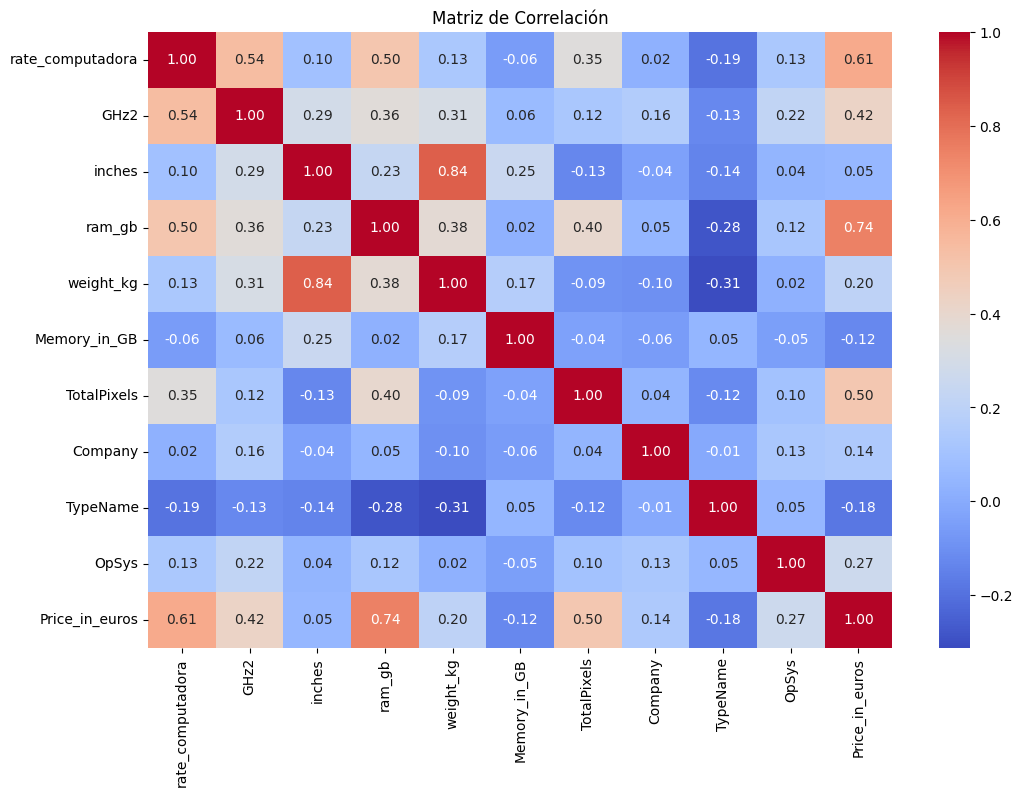

In [35]:
# Graficar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

### 3. Baseline de modelos


La regresión lineal es un modelo simple que sirve como una excelente línea de base. Es fácil de interpretar y rápida de entrenar. Este modelo asume una relación lineal entre las variables predictoras (features) y el target (precio).

In [36]:
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [37]:
# Instanciar y entrenar el modelo Random Forest
rf_model = RandomForestRegressor(max_depth=10)
rf_model.fit(X_train[features], y_train)

# Predecir y calcular RMSE
y_pred_rf = rf_model.predict(X_test[features])
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE Random Forest: {rmse_rf:.3f}')

RMSE Random Forest: 369.571


### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [38]:
from sklearn.model_selection import GridSearchCV, KFold

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [189,190,191,192,193,194],  # Número de árboles
    'max_depth': [2, 5, 10, None],            # Profundidad máxima
    'min_samples_split': [5, 10],            # Mínimas muestras para dividir
    'min_samples_leaf': [2, 4],               # Mínimas muestras en la hoja
    'bootstrap': [True]
}
# Crear el modelo
rf = RandomForestRegressor(random_state=42)



# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', 
                           cv=5, verbose=1, n_jobs=-1)

# Ajustar el Grid Search
grid_search.fit(X_train[features], y_train)

# Obtener los mejores hiperparámetros
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")

# Predecir y evaluar el modelo optimizado
best_rf = grid_search.best_estimator_
y_pred_Brf = best_rf.predict(X_test[features])
rmse_optimized_rf = np.sqrt(mean_squared_error(y_test, y_pred_Brf))
print(f'RMSE Random Forest optimizado: {rmse_optimized_rf:.3f}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 189}
RMSE Random Forest optimizado: 341.581


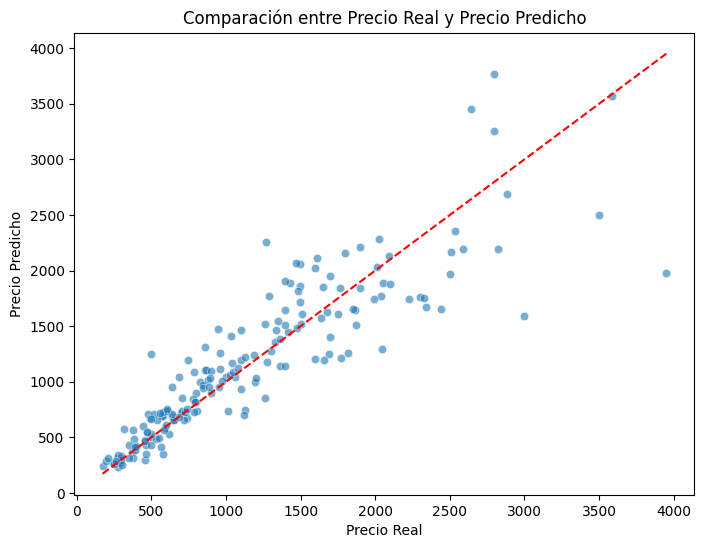

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_Brf, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de referencia
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Comparación entre Precio Real y Precio Predicho')
plt.show()

In [40]:
y_test

laptop_ID
451     1099.00
802      959.00
723      857.07
682      699.00
1306     369.00
         ...   
369      639.00
626      379.00
416      304.45
546      859.00
260      949.00
Name: Price_in_euros, Length: 183, dtype: float64

In [41]:
# Crear un DataFrame para comparar los valores reales y los predichos
comparacion = pd.DataFrame({'Precio Real': y_test, 'Precio Predicho': y_pred_Brf})

# Mostrar las primeras filas de la comparación
print(comparacion.head(10))  # Mostrar las primeras 10 filas

           Precio Real  Precio Predicho
laptop_ID                              
451            1099.00      1199.874346
802             959.00      1113.273488
723             857.07      1109.041290
682             699.00       719.960499
1306            369.00       370.209569
437             269.00       316.612193
22              999.00      1039.943481
322             459.90       296.860865
357            1304.00      1278.054763
174            1349.00      1543.093298


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [42]:
X_pred = pd.read_csv("./data/datatops/test.csv")
X_pred.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1,1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
2,1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
3,1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
4,1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


 ## 2. Replicar el procesado para ``test.csv``

In [43]:
X_pred.reset_index(drop=True)
X_pred.index = X_pred["laptop_ID"]
X_pred.drop(["laptop_ID"], axis=1, inplace=True)

In [44]:

X_pred[['Cpu_marca', 'Cpu_modelo', 'Cpu_generacion', 'Cpu_frecuencia']] = X_pred['Cpu'].apply(extract_cpu_features)
X_pred["CPU_score"] = X_pred["Cpu_modelo"].apply(cpu_score)
X_pred["gpu_score"] = X_pred["Gpu"].apply(gpu_score)
X_pred["rate_computadora"] = X_pred["CPU_score"]*X_pred["gpu_score"]

X_pred["GHz2"] = X_pred["Cpu_frecuencia"]*1
X_pred["inches"] = X_pred.Inches.astype(float)
X_pred['ram_gb'] = X_pred['Ram'].str.replace('GB', '').astype(int)
X_pred["weight_kg"] = X_pred['Weight'].str.replace('kg', '').astype(float)
X_pred['Memory_in_GB'] = X_pred['Memory'].apply(extract_memory_size)

X_pred[['ScreenWidth', 'ScreenHeight', 'TotalPixels']] = X_pred['ScreenResolution'].apply(extract_screen_resolution)
X_pred['ResolutionCategory'] = X_pred['TotalPixels'].apply(classify_resolution)


X_pred[categorical_columns] = ordinal_encoder.transform(X_pred[categorical_columns])
X_pred[numeric_columns] = scaler.transform(X_pred[numeric_columns])




In [45]:
X_pred[features].head(5)

,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,TotalPixels,Company,TypeName,OpSys
laptop_ID,,,,,,,,,,
209,0.796610,0.703704,0.662651,0.225806,0.426434,0.247059,0.141403,10.0,1.0,4.0
1281,0.118644,0.259259,0.662651,0.032258,0.426434,0.241176,0.000000,0.0,3.0,2.0
1168,0.186441,0.407407,0.662651,0.032258,0.301746,0.498039,0.000000,10.0,3.0,4.0
1231,0.525424,0.592593,0.662651,0.096774,0.374314,0.121569,0.141403,4.0,0.0,5.0
1020,0.525424,0.592593,0.469880,0.032258,0.314214,0.121569,0.141403,7.0,3.0,5.0


In [46]:
X_train[features].head(5)

,rate_computadora,GHz2,inches,ram_gb,weight_kg,Memory_in_GB,TotalPixels,Company,TypeName,OpSys
laptop_ID,,,,,,,,,,
1118,0.389831,0.629630,0.867470,0.096774,0.576060,0.498039,0.141403,7.0,5.0,7.0
153,0.796610,0.703704,0.662651,0.225806,0.466334,0.247059,0.141403,4.0,1.0,5.0
275,0.542373,0.740741,0.385542,0.096774,0.169576,0.247059,0.420536,1.0,4.0,8.0
1100,0.186441,0.518519,0.469880,0.032258,0.211970,0.241176,0.141403,7.0,3.0,7.0
131,0.491525,0.333333,0.867470,0.225806,0.526185,0.121569,0.141403,4.0,3.0,5.0


In [47]:
predictions_submit =  best_rf.predict(X_pred[features])

In [48]:
# Crear un DataFrame para comparar los valores reales y los predichos
comparacion = pd.DataFrame({'Precio Predicho': predictions_submit})

# Mostrar las primeras filas de la comparación
print(comparacion.head(10))  # Mostrar las primeras 10 filas

   Precio Predicho
0      1471.460682
1       311.693561
2       398.604953
3       974.469892
4       904.361757
5       538.784123
6       800.079615
7      1007.514513
8      1311.278344
9       417.111230


**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

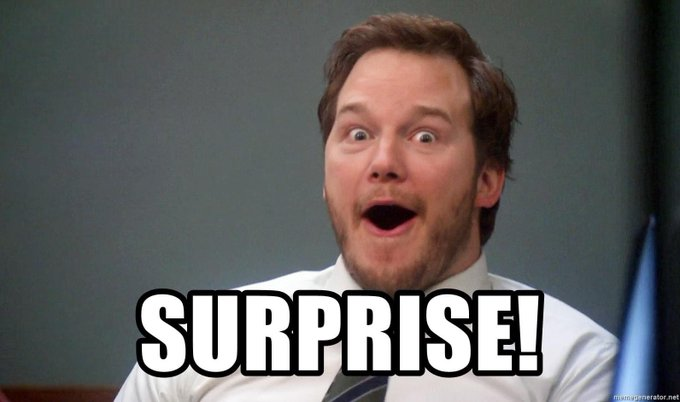

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [49]:
sample = pd.read_csv("data/datatops/sample_submission.csv")

In [50]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [51]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [52]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(predictions_submit)

In [53]:
X_pred[target] = predictions_submit

In [54]:
submission = pd.DataFrame({'Precio Predicho': X_pred[target]})

In [55]:
submission.reset_index(inplace=True)

In [56]:
submission

,laptop_ID,Precio Predicho
0,209,1471.460682
1,1281,311.693561
2,1168,398.604953
3,1231,974.469892
4,1020,904.361757
...,...,...
386,820,2095.190324
387,948,916.939992
388,483,1817.568452
389,1017,928.577645


In [57]:
submission.rename(columns={"Precio Predicho": "Price_in_euros"}, errors="raise", inplace=True)

In [58]:
sample

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6
...,...,...
386,820,474.3
387,948,1468.8
388,483,520.4
389,1017,515.1


### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [59]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Lucas: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [60]:
chequeador(submission)

You're ready to submit!
